In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import preprocessor as p

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
encoded_label_dict = {"n" : 0, "y" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)

In [5]:
fp = "../data/REVISION DATASET_b.xlsx"
df = pd.read_excel(fp,sheet_name="data")

In [6]:
df.head()

,fullname,is_retweet,likes,replies,retweets,text,expresses a pain point,timestamp,timestamp_epochs,tweet_id,tweet_url,user_id,username,BRAND,Type of Pain,Subjectivity,Second category,Third category,Fourth category,Dataset
0,Emmanuel Olabode,0,1,1,1,@ifemeetstech your pr team can help bridge the...,y,42176,1434841837,612397168788406016,/olabodeEO/status/612397168788406272,1955234486,olabodeEO,gap,Operational issues,NaN,NaN,NaN,NaN,Original
1,Alviniecððâ¨,0,0,0,0,mcdonalds really bein missing uhp people food ...,y,2014-09-01 23:25:17,1409613917,506583600599662592,/ohhamazing/status/506583600599662592,2723652417,ohhamazing,mcdonalds,Product feature or quality,NaN,NaN,NaN,NaN,Original
2,Bobby,0,0,0,0,"if they thought that little of him, why was he...",y,43720,1568242832,1171921495309910016,/Bobbythegreat/status/1171921495309914112,33740752,Bobbythegreat,gap,Product feature or quality,NaN,NaN,NaN,NaN,Original
3,Elgen Bodenstien,0,0,0,0,when towns have locally owned business capita...,y,2019-09-05 23:34:22,1567726462,1169755684122086912,/bodenstien/status/1169755684122087424,1167585352464424960,bodenstien,walmart,Company's image,NaN,NaN,NaN,NaN,Original
4,Robyn,0,3,1,1,@arma_vancouver health information in records ...,y,2019-01-23 22:43:08,1548283388,1088205518886190976,/RobynCBird/status/1088205518886191104,2206030555,RobynCBird,fitbit,Company's image,NaN,NaN,NaN,NaN,Original


In [7]:
df = df[["text","expresses a pain point"]]

In [8]:
df["target"] = df["expresses a pain point"].apply(lambda x: encode_label(x))

In [9]:
def preprocess(txt):
    return p.clean(txt)

In [10]:
df["clean_text"] = df["text"].apply(lambda x: preprocess(x))

In [11]:
df.head()

,text,expresses a pain point,target,clean_text
0,@ifemeetstech your pr team can help bridge the...,y,1,your pr team can help bridge the communication...
1,mcdonalds really bein missing uhp people food ...,y,1,mcdonalds really bein missing uhp people food ...
2,"if they thought that little of him, why was he...",y,1,"if they thought that little of him, why was he..."
3,when towns have locally owned business capita...,y,1,when towns have locally owned business capital...
4,@arma_vancouver health information in records ...,y,1,health information in records means vulnerabil...


In [12]:
df.target.value_counts()

0    3348
1    1252
Name: target, dtype: int64

<AxesSubplot:>

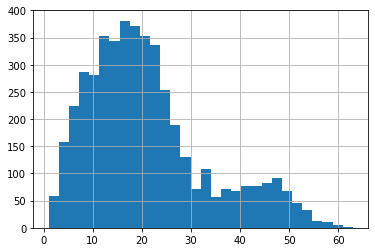

In [13]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df.clean_text]

pd.Series(seq_len).hist(bins = 30)

In [14]:
model_name = "roberta-base"
MAX_LEN = 35
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-05

In [15]:
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [16]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.clean_text[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [17]:
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, stratify=None, random_state=2021)
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, stratify=None, random_state=2021)

In [18]:
# Creating the dataset and dataloader
train_dataset = train.reset_index(drop=True)
valid_dataset = valid.reset_index(drop=True)
test_dataset = test.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
validating_set = Triage(valid_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (4600, 4)
TRAIN Dataset: (3680, 4)
VALID Dataset: (460, 4)
TEST Dataset: (460, 4)


In [19]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validating_set, **valid_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
def validate(model, testing_loader):
    model.eval()
    n_correct = 0
    n_wrong = 0
    total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    state = torch.get_rng_state()
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, attention_mask=mask, labels=targets)
            loss = outputs.loss
            logits = outputs.logits
            tr_loss += loss
            big_val, big_idx = torch.max(logits, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    torch.set_rng_state(state)
    return epoch_loss, epoch_accu

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the roberta model
def train(epoch, training_loader, testing_loader, lr_sched):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        
        optimizer.zero_grad()
        outputs = model(ids, attention_mask=mask, labels=targets)
        loss = outputs.loss
        logits = outputs.logits
        tr_loss += loss
        big_val, big_idx = torch.max(logits, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _!=0 and _%100==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 100 steps: {loss_step}")
            print(f"Training Accuracy per 100 steps: {accu_step}")

        loss.backward()
        optimizer.step()
        lr_sched.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    
    valid_loss, valid_accu = validate(model,testing_loader)
    return model, epoch_loss, epoch_accu, valid_loss, valid_accu

In [ ]:
torch.manual_seed(2021)

model = RobertaForSequenceClassification.from_pretrained(model_name)
model.to(device)

# Creating the optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(training_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

running_val_loss = float('inf')
running_trn_loss = float('inf')
trn_losses = []
val_losses = []
for epoch in range(num_epochs):
    m, trn_loss, trn_acc, val_loss, val_acc = train(epoch, training_loader, validating_loader, lr_scheduler)
    trn_losses.append(trn_loss)
    val_losses.append(val_loss)
    if (val_loss < running_val_loss) and (val_loss < trn_loss):
        running_val_loss = val_loss
        running_trn_loss = trn_loss
        # Save the best model
        output_model_file = f'../models/best-ft-roberta-painpoint-maxlen35-bs16-lr-sched.pt'
        model_to_save = m
        torch.save(model_to_save, output_model_file)

In [ ]:
# Plot Epoch vs Loss Graph

#### Inference

In [20]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import torch

In [21]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [22]:
model = torch.load('../models/best-ft-roberta-painpoint-maxlen35-bs16-lr-sched.pt')

In [23]:
def predict(query, model, tokenizer, device="cuda"):
    tokens = tokenizer.encode(query)
    all_tokens = len(tokens)
    tokens = tokens[:tokenizer.model_max_length - 2]
    used_tokens = len(tokens)
    tokens = torch.tensor([tokenizer.bos_token_id] + tokens + [tokenizer.eos_token_id]).unsqueeze(0)
    mask = torch.ones_like(tokens)

    with torch.no_grad():
        logits = model(tokens.to(device), attention_mask=mask.to(device))[0]
        probs = logits.softmax(dim=-1)

    fake, real = probs.detach().cpu().flatten().numpy().tolist()
    return real

In [24]:
query = """This is bad.
"""
predict(query,model,tokenizer)

0.08806031942367554

In [25]:
preds, preds_probas = [],[]
for i, row in test_dataset.iterrows():
    query = row["clean_text"]
    pred = predict(query,model,tokenizer)
    preds_probas.append(pred)
    if pred >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

In [26]:
from sklearn.metrics import confusion_matrix
y_true = test_dataset.target.values
y_pred = preds
confusion_matrix(y_true,y_pred)

array([[315,  17],
       [ 54,  74]])

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
acc = accuracy_score(y_true,y_pred)
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

In [28]:
print(f"Accuracy: {acc*100}; Precision:{precision*100}; Recall:{recall*100}")

Accuracy: 84.56521739130434; Precision:81.31868131868131; Recall:57.8125


In [29]:
print(classification_report(y_true, y_pred, target_names=["n","y"]))

              precision    recall  f1-score   support

           n       0.85      0.95      0.90       332
           y       0.81      0.58      0.68       128

    accuracy                           0.85       460
   macro avg       0.83      0.76      0.79       460
weighted avg       0.84      0.85      0.84       460

